In [1]:
import os
import stlearn as st
import pandas as pd, numpy as np

from typing import Optional, Union
from anndata import AnnData
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
import scanpy as sc
#import stlearn.plotting.utils as utils

import warnings
warnings.filterwarnings("ignore")

/home/uqfzha11/miniforge3/envs/stlearn/lib/python3.8/site-packages/stlearn/tools/microenv/cci/het.py:192: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(parallel=True, nopython=False)


In [2]:
def deconvolution_plot(
    adata: AnnData,
    library_id: str = None,
    use_label: str = "louvain",
    cluster: [int, str] = None,
    celltype: str = None,
    celltype_threshold: float = 0,
    data_alpha: float = 1.0,
    threshold: float = 0.0,
    cmap: str = "tab20",
    colors: dict = None,  # The colors to use for each label...
    tissue_alpha: float = 1.0,
    title: str = None,
    spot_size: Union[float, int] = 10,
    show_axis: bool = False,
    show_legend: bool = True,
    show_donut: bool = True,
    cropped: bool = True,
    margin: int = 100,
    name: str = None,
    dpi: int = 150,
    output: str = None,
    copy: bool = False,
    figsize: tuple = (6.4, 4.8),
    show=True,
) -> Optional[AnnData]:

    """
    Clustering plot for sptial transcriptomics data. Also it has a function to display trajectory inference.

    Parameters
    ----------
    adata
        Annotated data matrix.
    library_id
        Library id stored in AnnData.
    use_label
        Use label result of cluster method.
    list_cluster
        Choose set of clusters that will display in the plot.
    data_alpha
        Opacity of the spot.
    tissue_alpha
        Opacity of the tissue.
    cmap
        Color map to use.
    spot_size
        Size of the spot.
    show_axis
        Show axis or not.
    show_legend
        Show legend or not.
    show_donut
        Whether to show the donut plot or not.
    show_trajectory
        Show the spatial trajectory or not. It requires stlearn.spatial.trajectory.pseudotimespace.
    show_subcluster
        Show subcluster or not. It requires stlearn.spatial.trajectory.global_level.
    name
        Name of the output figure file.
    dpi
        DPI of the output figure.
    output
        Save the figure as file or not.
    copy
        Return a copy instead of writing to adata.
    Returns
    -------
    Nothing
    """

    # plt.rcParams['figure.dpi'] = dpi

    imagecol = adata.obs["imagecol"]
    imagerow = adata.obs["imagerow"]

    fig, ax = plt.subplots(figsize=figsize)

    label = adata.obsm["deconvolution"].T
    
    label = label.sort_index(ascending=False)

    tmp = label.sum(axis=1)

    label_filter = label.loc[tmp[tmp >= np.quantile(tmp, threshold)].index]

    if cluster is not None:
        base = adata.obs[adata.obs[use_label] == str(cluster)][["imagecol", "imagerow"]]
    else:
        base = adata.obs[["imagecol", "imagerow"]]

    if celltype is not None:
        base = base.loc[
            adata.obs_names[adata.obsm["deconvolution"][celltype] > celltype_threshold]
        ]

    label_filter_ = label_filter[base.index]
    colors = [colors[i] for i in label_filter_.index]
    my_cmap = mpl.colors.LinearSegmentedColormap.from_list('my_cmap', colors, N=len(colors))
    my_norm = mpl.colors.Normalize(0, len(label_filter_))
    color_vals = list(range(0, len(label_filter_), 1))

    if type(colors) == type(None):
        color_vals = list(range(0, len(label_filter_), 1))
        my_norm = mpl.colors.Normalize(0, len(label_filter_))
        my_cmap = mpl.cm.get_cmap(cmap, len(color_vals))
        colors = my_cmap.colors
            
    for i, xy in enumerate(base.values):
        _ = ax.pie(
            label_filter_.T.iloc[i].values,
            colors=colors,
            center=(xy[0], xy[1]),
            radius=spot_size,
            frame=True,
        )
    ax.autoscale()

    if library_id is None:
        library_id = list(adata.uns["spatial"].keys())[0]

    image = adata.uns["spatial"][library_id]["images"][
        adata.uns["spatial"][library_id]["use_quality"]
    ]

    if show_donut:
        ax_pie = fig.add_axes([0.5, -0.4, 0.03, 0.5])

        def my_autopct(pct):
            return ("%1.0f%%" % pct) if pct >= 4 else ""

        ax_pie.pie(
            label_filter_.sum(axis=1),
            colors=colors,
            radius=10,
            # frame=True,
            autopct=my_autopct,
            pctdistance=1.1,
            startangle=90,
            wedgeprops=dict(width=(3), edgecolor="w", antialiased=True),
            textprops={"fontsize": 5},
        )

    if show_legend == True:
        ax_cb = fig.add_axes([0.9, 0.25, 0.03, 0.5], axisbelow=False)
        cb = mpl.colorbar.ColorbarBase(
            ax_cb, cmap=my_cmap, norm=my_norm, ticks=color_vals, 
        )

        cb.ax.tick_params(size=0)
        loc = np.array(color_vals) + 0.5
        cb.set_ticks(loc)
        cb.set_ticklabels(label_filter_.index)
        cb.outline.set_visible(False)

    # Overlay the tissue image
    ax.imshow(
        image,
        alpha=1,
        zorder=-1,
    )

    ax.axis("off")

    if cropped:
        ax.set_xlim(imagecol.min() - margin, imagecol.max() + margin)

        ax.set_ylim(imagerow.min() - margin, imagerow.max() + margin)

        ax.set_ylim(ax.get_ylim()[::-1])

        # plt.gca().invert_yaxis()

    if name is None:
        name = use_label

    if output is not None:
        fig.savefig(output + "/" + name, dpi=dpi, bbox_inches="tight", pad_inches=0)

    if show:
        plt.show()

In [3]:
color_dict = {
    "DC" : "#5f9d9e",
    "Endothelial Cell" : "#f8a41e",
    "Fibroblast" : "#458b41",
    "KC Basal" : "#f16b6b",
    "KC Cornified" : "#9a1f61",
    "KC Granular" : "#c72685",
    "KC Differentiating" : "#9583bd",
    "KC Hair" : "#eb2627",
    "LC" :"#37479b",
    "Macrophage" : "#eae71d",
    "Melanocytes" : "#8b471f",
    "NK" : "#99ca3e",
    "T Cell" : "#41baeb",
    "Mast Cell" : "#7f8133",
    "B Cell" : "#fed9b9",
    "Pericytes" : "#dca566",
    "Sweat gland related" : "#f2634b",
   'Plasma' : '#f1ea9d',
   'KC IFN' : '#f06ba8', 
   "Monocytes" :"#9cc7a1",
   "KC Dysplastic" : "#d8c0dd"
}


In [4]:
def celltype_prop_plot(data_path, spot_mixtures_path, name, out_dir):
    spot_mixtures = pd.read_csv(spot_mixtures_path,index_col=0)
    #spot_mixtures.T.to_csv(spot_mixtures_path.replace(".csv","_T.csv"))
    data = st.Read10X(data_path,
                        count_file='filtered_feature_bc_matrix.h5', quality = "hires",
                        image_path = "spatial/tissue_hires_image.png")
    data = data[data.obs.index.isin(spot_mixtures.index)]
    st.add.add_deconvolution(data,annotation_path=spot_mixtures_path.replace(".csv","_T.csv"))
    deconvolution_plot(data, show_legend = True, figsize = (15,7.5), cropped=True, dpi=1200, cmap=None, colors=color_dict, name=name, output=out_dir)
    return data

In [5]:
# set path ------------------
output_dir = '/scratch/project/stseq/Feng/projects/SkinCancerAtlas/Revision/manuscript_code/fig5'
os.chdir(output_dir)

### B18_BCC

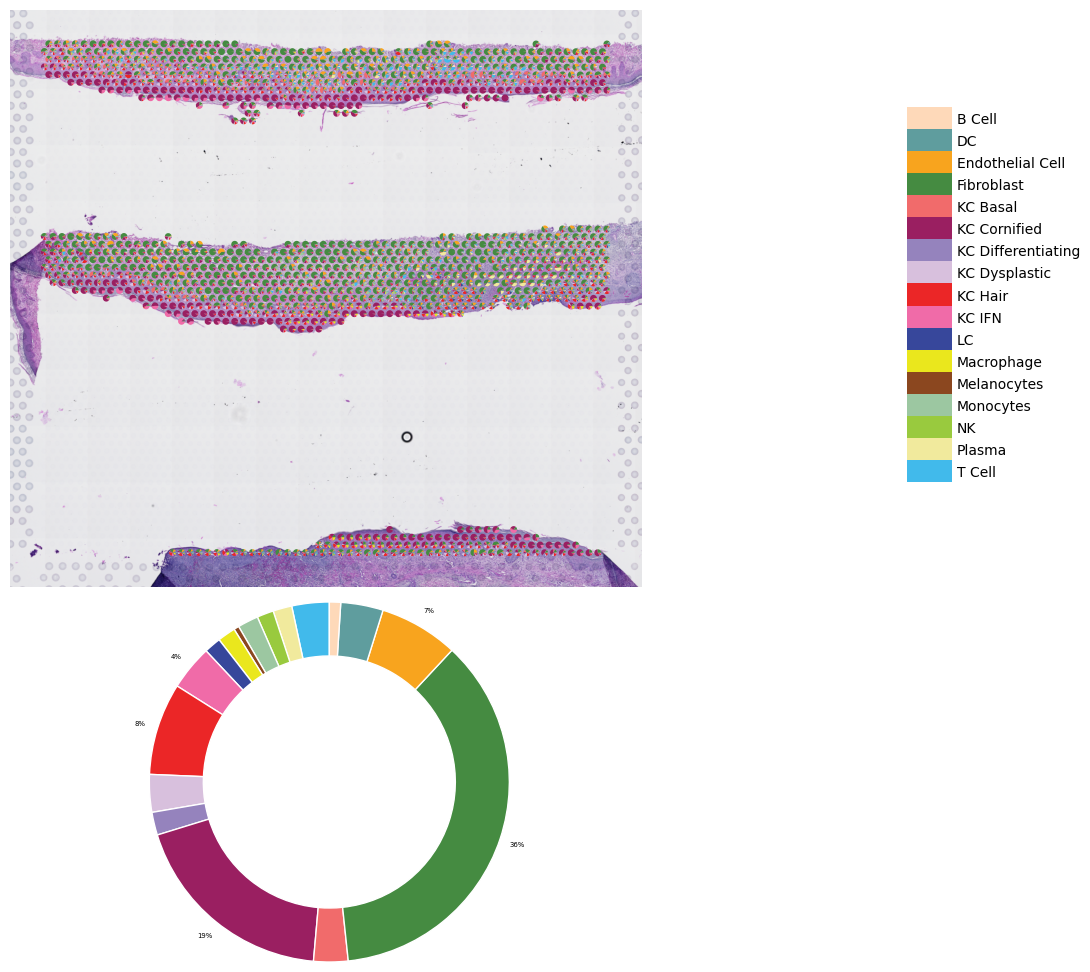

In [21]:
# cell type
spot_mixtures_path = "/scratch/project/stseq/Levi/SkinCancerAtlas/visium_card/B18_BCC_CARD_Nov2024.csv"
data_path = "/QRISdata/Q2051/SCC_Paper/figures/Fig2_VisiumNanostring/previous_versions/Fig3_VisiumNanostring_celltypes/working_data/Visium32_BCC_SCC/A1_B18BCC/outs/"
adata = celltype_prop_plot(data_path, spot_mixtures_path, name="visium_B18_BCC_celltype.pdf", out_dir="./")

In [ ]:
# tissue coloured by gene expression

In [22]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)



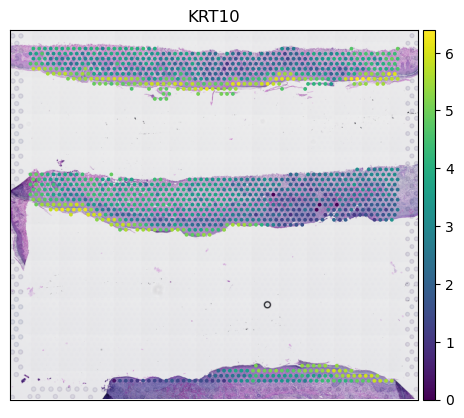

In [26]:
sc.pl.spatial(adata, img_key="hires", color=["KRT10"], show=False, return_fig=True) #SBSN
plt.gca().set_xlabel('')  # Remove x-axis label
plt.gca().set_ylabel('')  # Remove y-axis label
plt.savefig(os.path.join(output_dir,'visium_B18_BCC_marker.pdf'), format="pdf", dpi=300, bbox_inches="tight")  # Save as PDF with high resolution


### B18_SCC

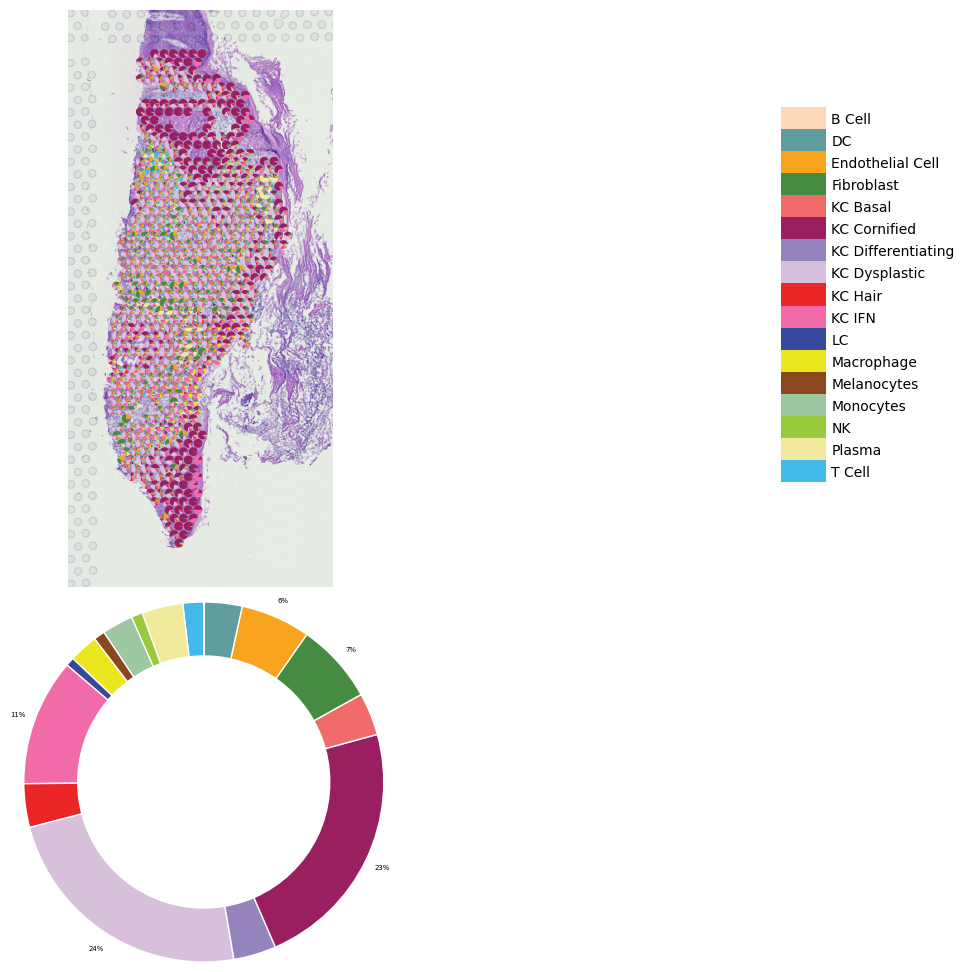

In [27]:
spot_mixtures_path = "/scratch/project/stseq/Levi/SkinCancerAtlas/visium_card/B18_SCC_CARD_Nov2024.csv"
data_path = "/QRISdata/Q2051/SCC_Paper/figures/Fig2_VisiumNanostring/previous_versions/Fig3_VisiumNanostring_celltypes/working_data/Visium9_BCC_SCC/Visium9_B1/B1/outs/"
adata = celltype_prop_plot(data_path, spot_mixtures_path, name="visium_B18_SCC_celltype.pdf", out_dir="./")

In [28]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

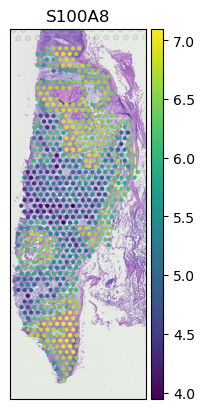

In [29]:
sc.pl.spatial(adata, img_key="hires", color=["S100A8"],legend_loc=None, show=False)
plt.gca().set_xlabel('')  # Remove x-axis label
plt.gca().set_ylabel('')  # Remove y-axis label
plt.savefig(os.path.join(output_dir,'visium_B18_SCC_marker.pdf'), format="pdf", dpi=300, bbox_inches="tight")  # Save as PDF with high resolution


### 48974_Mel

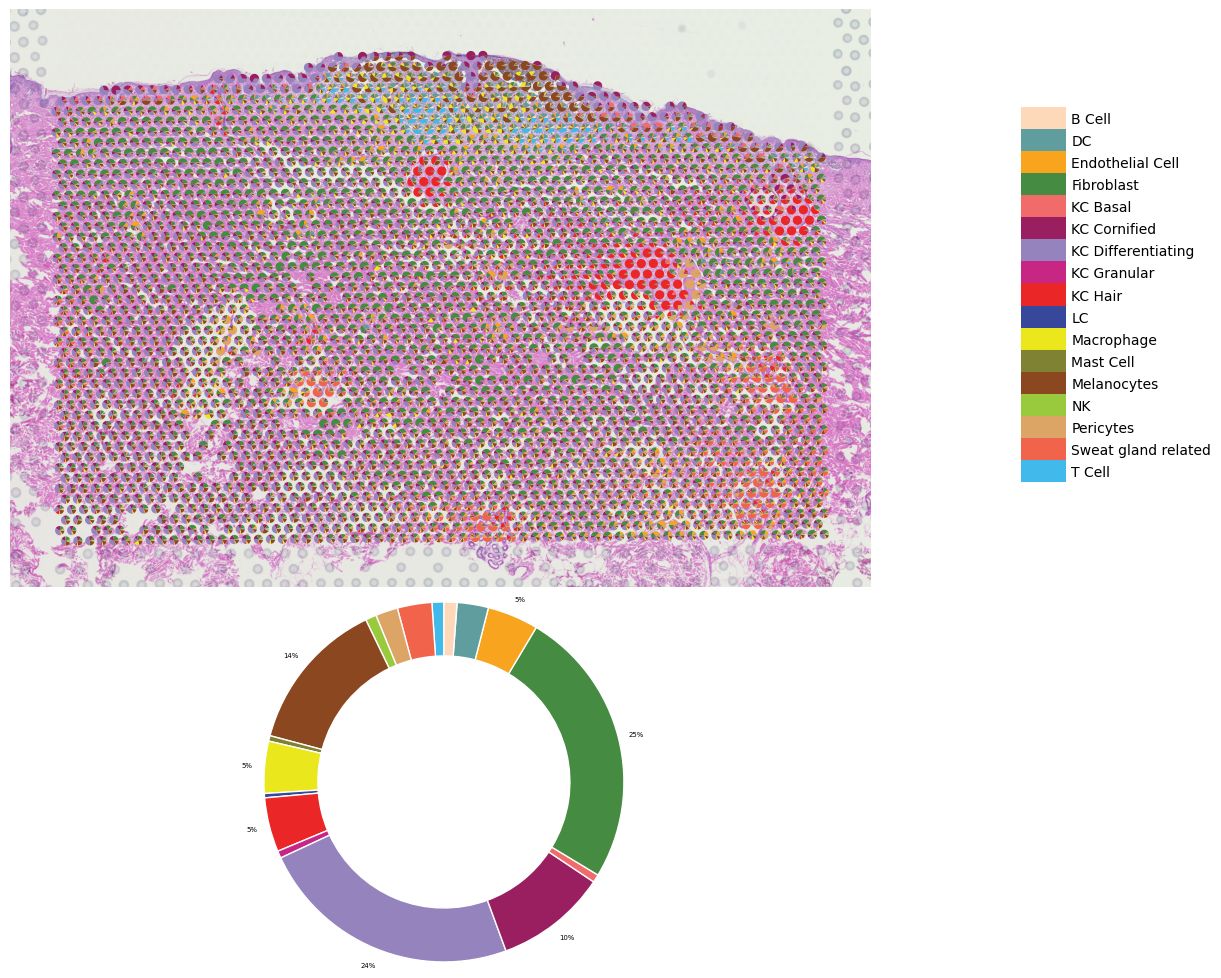

In [23]:
spot_mixtures_path = "/scratch/project/stseq/Levi/SkinCancerAtlas/visium_card/48974_Mel_CARD_Nov2024.csv"
data_path = "/QRISdata/Q2051/SCC_Paper/figures/Fig2_VisiumNanostring/previous_versions/Fig3_VisiumNanostring_celltypes/working_data/Visium25_Melanoma/FFPE_A1s1_66487_48974/outs"
adata = celltype_prop_plot(data_path, spot_mixtures_path, name="visium_48974_Mel_celltype.pdf", out_dir="./")

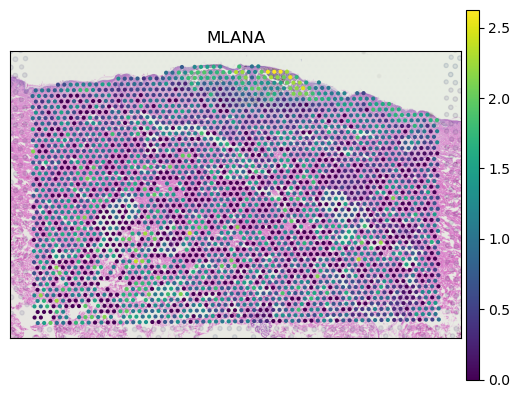

In [24]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

sc.pl.spatial(adata, img_key="hires", color=["MLANA"],legend_loc=None, show=False)
plt.gca().set_xlabel('')  # Remove x-axis label
plt.gca().set_ylabel('')  # Remove y-axis label
plt.savefig(os.path.join(output_dir,'visium_48974_Mel_MLANA.pdf'), format="pdf", dpi=300, bbox_inches="tight")  # Save as PDF with high resolution
